In [1]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as nps
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from scipy.stats import *

import warnings
# Suprimir todos os warnings
warnings.filterwarnings("ignore")

/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/gabriel/.local/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
#ponte de conexão com o redshift
#connection = psycopg2.connect(dbname="dw_amorsaude",
#                 user="gabriel_guilherme",
#                 password="PgQ1yBg9hzHJfmc",
#                 host ="amorsaude-cluster-redshift.cmc4ev2oyczd.us-east-1.redshift.amazonaws.com",
#                  port = 5439)


In [3]:
class CustomException(Exception):
    pass

json_manifest_dbt = "target/manifest.json"
athena_bucket = "todos-athena-us-east-1"
athena_tmp_folder = f"s3://{athena_bucket}/"

In [4]:
def execute_athena_sql(query):
    client = boto3.client('athena', region_name='us-east-1')
    queryStart = client.start_query_execution(
    QueryString = query,
    ResultConfiguration = { 'OutputLocation': athena_tmp_folder})
    queryExecution = client.get_query_execution(QueryExecutionId=queryStart['QueryExecutionId'])
    while queryExecution['QueryExecution']['Status']['State'] in ('RUNNING', 'QUEUED'):
        time.sleep(5)
        queryExecution = client.get_query_execution(QueryExecutionId=queryStart['QueryExecutionId'])

In [5]:
        def execute_athena_query(query):
    cursor = connect(s3_staging_dir=athena_tmp_folder,
                    region_name="us-east-1").cursor()
    cursor.execute(query)
    colls=','.join(str(f"{e[0]}") for e in cursor.description)
    results=pd.DataFrame(list(cursor), columns=colls.split(","))
    return results

In [6]:
# Carregando o arquivo Excel em um DataFrame
caminho_arquivo = '/home/gabriel/dbt-projects/python_files/analises/files/Relatorio_Atendimentos Uberlandia - mês 09 e 10 filtrado.xlsx'
nome_aba = 'Resultado Filtrado'
dfrelatorio_atendimento = pd.read_excel(caminho_arquivo, sheet_name=nome_aba)

In [7]:
dfrelatorio_atendimento['Unnamed: 10'] = dfrelatorio_atendimento['LOCAL'].str.split('-', n=1).str[0]
dfrelatorio_atendimento

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10
0,NaN,E1,EXAMES,2023-09-01,07:03:21,00:00:39,00:00:01,00:00:40,Debora Silva Lopes,GUICHÊS-2,GUICHÊS
1,NaN,E2,EXAMES,2023-09-01,07:11:05,00:00:11,00:00:25,00:00:36,Debora Silva Lopes,GUICHÊS-2,GUICHÊS
2,NaN,P1,ULTRASSOM,2023-09-01,07:18:43,00:00:58,00:01:35,00:02:33,Giovana Cristina,GUICHÊS-1,GUICHÊS
3,Jose Ricardo De Paula Nunes,M1,ATENDIMENTO MEDICO,2023-09-01,07:18:52,00:06:52,00:03:34,00:10:26,Ivina Renata,GUICHÊS-02,GUICHÊS
4,NaN,E3,EXAMES,2023-09-01,07:21:45,00:00:16,00:00:20,00:00:36,Giovana Cristina,GUICHÊS-1,GUICHÊS
...,...,...,...,...,...,...,...,...,...,...,...
22012,Maria De Fatima De Jesus,M210,ATENDIMENTO MEDICO,2023-10-31,17:05:55,00:00:04,00:00:27,00:00:31,Ivina Renata,GUICHÊS-01,GUICHÊS
22013,Maria De Fatima De Jesus,M210,DRA. ANNELISE DE MACEDO,2023-10-31,17:05:55,00:07:48,00:07:50,00:15:38,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO
22014,Brayan Fernandes De Jesus,A60,DRA. DENISE DOS SANTOS PASSOS,2023-10-31,17:12:42,00:20:15,00:07:33,00:27:48,Dra.Denise Dos Santos Passos,CONSULTÓRIO-05,CONSULTÓRIO
22015,NaN,R23,RESULTADO DE EXAMES,2023-10-31,17:32:14,00:19:45,00:00:02,00:19:47,Ivina Renata,GUICHÊS-01,GUICHÊS


In [8]:
# Selecione as colunas que você deseja converter para o tipo time
colunas_tempo = ['EMISSAO', 'TEMPO ESPERA', 'TEMPO ATENDIMENTO']

# Itere sobre as colunas selecionadas e converta para o tipo time
for coluna in colunas_tempo:
    dfrelatorio_atendimento[coluna] = pd.to_datetime(dfrelatorio_atendimento[coluna], format='%H:%M:%S').dt.time

In [9]:
colunas_tempo = ['EMISSAO', 'TEMPO ESPERA', 'TEMPO ATENDIMENTO']

for coluna in colunas_tempo:
    # Crie uma nova coluna com o sufixo '_decimal' para armazenar os valores convertidos
    dfrelatorio_atendimento[coluna + '_DECIMAL'] = pd.to_datetime(dfrelatorio_atendimento[coluna], format='%H:%M:%S').dt.time
    dfrelatorio_atendimento[coluna + '_DECIMAL'] = pd.to_timedelta(dfrelatorio_atendimento[coluna + '_DECIMAL'].astype(str)).dt.total_seconds() / 3600.0

In [10]:
colunas_decimal = ['EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

# Multiplique os valores por 60
dfrelatorio_atendimento[colunas_decimal] = dfrelatorio_atendimento[colunas_decimal].multiply(60)

In [11]:
#Retiro tudo que for acima de 60 minutos, indicando uma espera acima de 1 hora (outlier)

colunas_decimal = ['TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

for coluna in colunas_decimal:
    dfrelatorio_atendimento = dfrelatorio_atendimento[dfrelatorio_atendimento[coluna] <= 60]

In [12]:
dfrelatorio_atendimento['EMISSAO_DECIMAL'] = dfrelatorio_atendimento['EMISSAO_DECIMAL'] / 60

In [13]:
# Verificar se há valores nulos em cada coluna
colunas_verificadas = ['EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

for coluna in colunas_verificadas:
    tem_dados_vazios = dfrelatorio_atendimento[coluna].isnull().any()
    if tem_dados_vazios:
        print(f"A coluna '{coluna}' tem valores vazios.")
    else:
        print(f"A coluna '{coluna}' não tem valores vazios.")

A coluna 'EMISSAO_DECIMAL' não tem valores vazios.
A coluna 'TEMPO ESPERA_DECIMAL' não tem valores vazios.
A coluna 'TEMPO ATENDIMENTO_DECIMAL' não tem valores vazios.


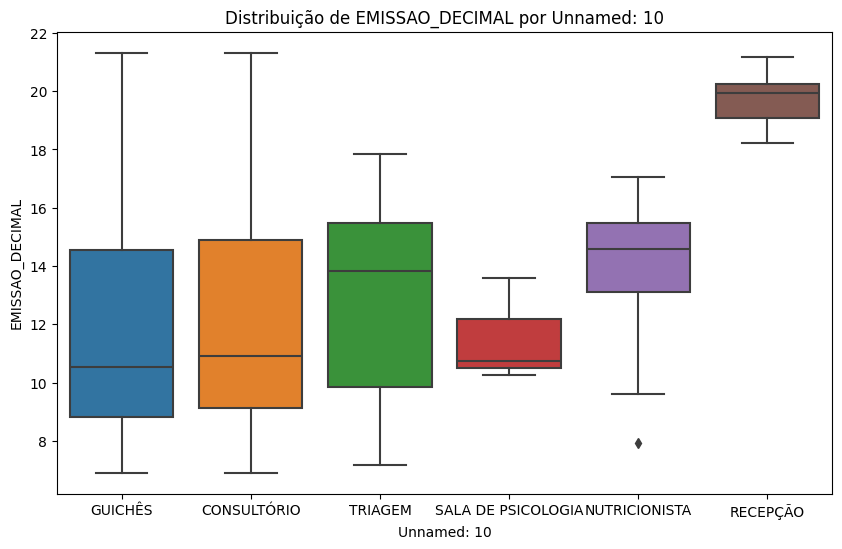

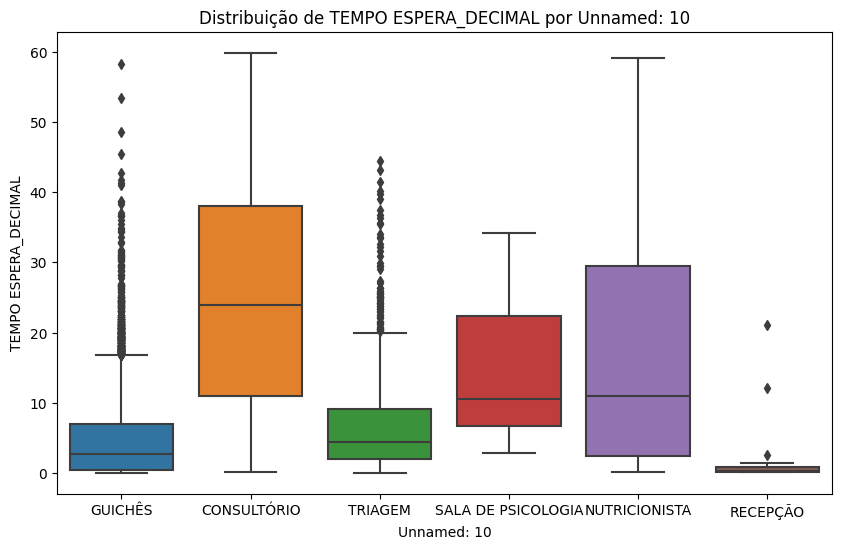

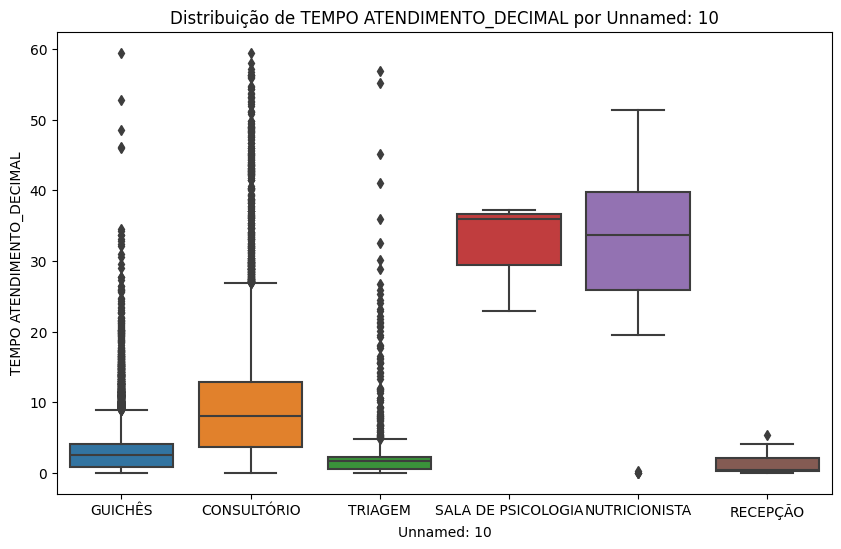

In [14]:
colunas_selecionadas = ['Unnamed: 10', 'EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']
df_selecionado = dfrelatorio_atendimento[colunas_selecionadas]

# Agrupe por 'Unnamed: 10' e calcule estatísticas descritivas
estatisticas_descritivas = df_selecionado.groupby('Unnamed: 10').describe()

# Exiba a tabela de estatísticas descritivas
estatisticas_descritivas

# Crie gráficos de caixa para cada coluna agrupada por 'Unnamed: 10'
for coluna in colunas_selecionadas[1:]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Unnamed: 10', y=coluna, data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por Unnamed: 10')
    plt.show()

In [15]:
estatisticas_descritivas

EMISSAO_DECIMAL                                             \
                             count       mean       std        min        25%   
Unnamed: 10                                                                     
CONSULTÓRIO                 6387.0  11.995160  3.266226   6.913056   9.134861   
GUICHÊS                    13288.0  11.585814  3.212731   6.913056   8.840278   
NUTRICIONISTA                 44.0  13.929148  2.360097   7.942778  13.106944   
RECEPÇÃO                      23.0  19.708502  0.914759  18.230278  19.077500   
SALA DE PSICOLOGIA             3.0  11.533426  1.802662  10.248889  10.503056   
TRIAGEM                     1154.0  12.901890  3.091154   7.166944   9.848125   

                                                    TEMPO ESPERA_DECIMAL  \
                          50%        75%        max                count   
Unnamed: 10                                                                
CONSULTÓRIO         10.918889  14.909861  21.315000               6387.0   
GUICHÊS             10.549583  14.552014  21.315000              13288.0   
NUTRICIONISTA       14.590278  15.468611  17.053889                 44.0   
RECEPÇÃO            19.952222  20.256667  21.163889                 23.0   
SALA DE PSICOLOGIA  10.757222  12.175694  13.594167                  3.0   
TRIAGEM             13.841528  15.489375  17.854722               1154.0   

                               ...                        \
                         mean  ...        75%        max   
Unnamed: 10                    ...                         
CONSULTÓRIO         25.350016  ...  38.075000  59.900000   
GUICHÊS              4.470367  ...   6.966667  58.300000   
NUTRICIONISTA       18.071212  ...  29.512500  59.216667   
RECEPÇÃO             1.868841  ...   0.783333  21.066667   
SALA DE PSICOLOGIA  15.838889  ...  22.316667  34.150000   
TRIAGEM              6.720133  ...   9.137500  44.516667   

                   TEMPO ATENDIMENTO_DECIMAL                               \
                                       count       mean        std    min   
Unnamed: 10                                                                 
CONSULTÓRIO                           6387.0   9.518895   8.989211   0.00   
GUICHÊS                              13288.0   3.089228   3.302799   0.00   
NUTRICIONISTA                           44.0  31.238636  12.476883   0.00   
RECEPÇÃO                                23.0   1.135507   1.448042   0.00   
SALA DE PSICOLOGIA                       3.0  32.016667   7.966510  22.85   
TRIAGEM                               1154.0   2.456658   4.695124   0.00   

                                                                
                          25%        50%        75%        max  
Unnamed: 10                                                     
CONSULTÓRIO          3.583333   8.000000  12.875000  59.466667  
GUICHÊS              0.750000   2.483333   4.016667  59.416667  
NUTRICIONISTA       25.937500  33.700000  39.779167  51.350000  
RECEPÇÃO             0.191667   0.450000   2.075000   5.283333  
SALA DE PSICOLOGIA  29.391667  35.933333  36.600000  37.266667  
TRIAGEM              0.533333   1.633333   2.250000  56.833333  

[6 rows x 24 columns]

In [16]:
from scipy.stats import kstest
from scipy.stats import norm, expon, gamma, weibull_min, beta,  erlang, cauchy, laplace, logistic, rayleigh, uniform, triang

# pareto #chi2

#Cria uma função para retornar a melhor distribuição:

def analisar_distribuicoes_por_local(df, colunas_decimais, grupo_coluna='Unnamed: 10'):
    for coluna_decimal in colunas_decimais:
        plt.figure(figsize=(10, 6))
        sns.histplot(df, x=coluna_decimal, hue=grupo_coluna, kde=True, common_norm=False)
        plt.title(f'Distribuição de {coluna_decimal} agrupada por {grupo_coluna}')
        plt.show()

    distribuicoes = [norm, expon, gamma, weibull_min, beta, erlang, cauchy, laplace, logistic, rayleigh, uniform, triang]

    for coluna_decimal in colunas_decimais:
        print(f"=== Resultados para {coluna_decimal} ===")
        for grupo, dados in df.groupby(grupo_coluna)[coluna_decimal]:
            melhor_distribuicao = None
            melhor_pvalue = float('inf')

            for distribuicao in distribuicoes:
                args = distribuicao.fit(dados)
                ks_statistic, pvalue = kstest(dados, distribuicao.cdf, args)

                if pvalue < melhor_pvalue:
                    melhor_pvalue = pvalue
                    melhor_distribuicao = distribuicao

            print(f"Grupo {grupo} - Melhor distribuição: {melhor_distribuicao.name}")
            print("Parâmetros da distribuição:", melhor_distribuicao.fit(dados))
            print("Estatísticas descritivas:")

In [17]:
from scipy.stats import kstest
from scipy.stats import norm, expon, gamma, weibull_min, beta, erlang, cauchy, laplace, logistic, rayleigh, uniform, triang

def analisar_distribuicoes_por_atendente2(df, colunas_decimais, coluna_grupo='Especialidade', distribuicoes=None):
    if distribuicoes is None:
        distribuicoes = [norm, expon, gamma, weibull_min, beta, erlang, cauchy, laplace, logistic, rayleigh, uniform, triang]

    for coluna_decimal in colunas_decimais:
        plt.figure(figsize=(10, 6))
        sns.histplot(df, x=coluna_decimal, hue=coluna_grupo, kde=True, common_norm=False)
        plt.title(f'Distribuição de {coluna_decimal} agrupada por {coluna_grupo}')
        plt.show()

    for coluna_decimal in colunas_decimais:
        print(f"=== Resultados para {coluna_decimal} ===")
        for grupo, dados in df.groupby(coluna_grupo)[coluna_decimal]:
            melhor_distribuicao = None
            melhor_pvalue = float('inf')

            for distribuicao in distribuicoes:
                # Ajuste da distribuição
                args = distribuicao.fit(dados)
                ks_statistic, pvalue = kstest(dados, distribuicao.cdf, args)

                if pvalue < melhor_pvalue:
                    melhor_pvalue = pvalue
                    melhor_distribuicao = distribuicao

            print(f"{coluna_grupo} {grupo} - Melhor distribuição: {melhor_distribuicao.name}")
            print("Parâmetros da distribuição:", melhor_distribuicao.fit(dados))  # Agora, mostra os parâmetros do melhor ajuste
            print("Estatísticas descritivas:")
            print(dados.describe())  # Adiciona estatísticas descritivas
            print("\n")

In [18]:
# Aplicando o filtro de recepção
df_filtro_recepcao = dfrelatorio_atendimento[(dfrelatorio_atendimento['TIPO ATENDIMENTO'] == 'ATENDIMENTO MEDICO') & (dfrelatorio_atendimento['Unnamed: 10'].isin(['GUICHÊS', 'RECEPCAO']))]
#filtro de triagem
df_filtro_triagem = dfrelatorio_atendimento[dfrelatorio_atendimento['TIPO ATENDIMENTO'].str.startswith(('DR.', 'DRA.')) & (dfrelatorio_atendimento['Unnamed: 10'] == 'TRIAGEM')]
# Aplicando o filtro separando o médico e sua especialidade
df_filtro_consultorio = dfrelatorio_atendimento[dfrelatorio_atendimento['TIPO ATENDIMENTO'].str.startswith(('DR.', 'DRA.')) & (dfrelatorio_atendimento['Unnamed: 10'] == 'CONSULTÓRIO')]

#retirado EMISSAO DECIMAL
colunas_decimais = ['TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

#retiro tudo que é menos que 4 minutos de atendimento dentro do df de médicos
for coluna in colunas_decimal:
    df_filtro_consultorio = df_filtro_consultorio[df_filtro_consultorio[coluna] >= 4]

In [19]:
# Lista de nomes de atendentes desejados
nomes_atendentes = [
    'Dr. Fransergio Ferreira',
    'Dra. Ludimila Viana',
    'Dra. Angela Fernandes',
    'Dra. Annelise de Macedo',
    'Dr. Enzo Borges',
    'Dra. Isabella Bastos',
    'Dr. Renato Leoni',
    'Dra. Leticia Maia',
    'Dra.Izabella Cunha Campos',
    'Dra. Roseli Maria De Oliveira Carvalho ',
    'Dr. Walter Tadeu',
    'Dr. Diego Umberto De Mendonca Biasi'
]

# Dicionário de mapeamento entre nomes de atendentes e especialidades
mapeamento_especialidades = {
    'Dr. Fransergio Ferreira': 'Clínica Médica',
    'Dra. Ludimila Viana': 'Clínica Médica',
    'Dra. Angela Fernandes': 'Clínica Médica',
    'Dra. Annelise de Macedo': 'Oftalmo',
    'Dr. Enzo Borges': 'Oftalmo',
    'Dra. Isabella Bastos': 'Oftalmo',
    'Dr. Renato Leoni': 'G.O',
    'Dra. Leticia Maia': 'G.O',
    'Dra.Izabella Cunha Campos': 'G.O',
    'Dra. Roseli Maria De Oliveira Carvalho ': 'Cardio',
    'Dr. Walter Tadeu': 'Cardio',
    'Dr. Diego Umberto De Mendonca Biasi': 'Dermato'
}

# Criando a nova coluna 'Especialidade' com base no mapeamento
df_filtro_consultorio['Especialidade'] = df_filtro_consultorio['ATENDENTE'].map(mapeamento_especialidades)

contagem_por_atendente_especialidade = df_filtro_consultorio.groupby(['ATENDENTE', 'Especialidade']).size().reset_index(name='Contagem')
print(contagem_por_atendente_especialidade)

                              ATENDENTE   Especialidade  Contagem
0   Dr. Diego Umberto De Mendonca Biasi         Dermato       226
1                       Dr. Enzo Borges         Oftalmo       280
2               Dr. Fransergio Ferreira  Clínica Médica       768
3                      Dr. Renato Leoni             G.O       117
4                      Dr. Walter Tadeu          Cardio        52
5                 Dra. Angela Fernandes  Clínica Médica        21
6               Dra. Annelise de Macedo         Oftalmo       288
7                  Dra. Isabella Bastos         Oftalmo         8
8                     Dra. Leticia Maia             G.O       117
9                   Dra. Ludimila Viana  Clínica Médica       102
10            Dra.Izabella Cunha Campos             G.O       158


In [20]:
df_filtro_consultorio

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,Especialidade
30,Jose Nunes Da Silva,A3,DRA. CATIA FERNANDES MOREIRA,2023-09-01,08:10:06,00:43:34,00:14:08,00:57:42,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,CONSULTÓRIO,8.168333,43.566667,14.133333,NaN
38,Ana Flavia Silva Teixeira,A4,DRA. EDILAINE CUSTÃ“DIO SILVA,2023-09-01,08:34:18,00:15:09,00:49:19,01:04:28,Dra. Edilaine Custodio Silva,CONSULTÓRIO-3,CONSULTÓRIO,8.571667,15.150000,49.316667,NaN
51,Elaine Maria Da Silva,P2,DR. WALTER TADEU,2023-09-01,08:52:22,00:08:16,00:05:10,00:13:26,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.872778,8.266667,5.166667,Cardio
84,Longino Goncalves Ferreira,A9,DRA. CATIA FERNANDES MOREIRA,2023-09-01,10:30:39,00:49:30,00:10:26,00:59:56,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,CONSULTÓRIO,10.510833,49.500000,10.433333,NaN
88,Solange Moreira Herber,O2,DRA. CATIA FERNANDES MOREIRA,2023-09-01,10:43:52,00:32:10,00:05:03,00:37:13,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,CONSULTÓRIO,10.731111,32.166667,5.050000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22010,\trayane Vitoria Fernandes De Carvalho,M209,DR. EDUARDO MIGUEL NOGUEIRA BARROS,2023-10-31,16:55:47,00:29:22,00:05:35,00:34:57,Dr. Eduardo Miguel Nogueira Barros,CONSULTÓRIO-6,CONSULTÓRIO,16.929722,29.366667,5.583333,NaN
22011,Nicolly Beatriz Martins Freitas,A59,DRA. DENISE DOS SANTOS PASSOS,2023-10-31,16:58:08,00:09:23,00:12:24,00:21:47,Dra.Denise Dos Santos Passos,CONSULTÓRIO-05,CONSULTÓRIO,16.968889,9.383333,12.400000,NaN
22013,Maria De Fatima De Jesus,M210,DRA. ANNELISE DE MACEDO,2023-10-31,17:05:55,00:07:48,00:07:50,00:15:38,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,17.098611,7.800000,7.833333,Oftalmo
22014,Brayan Fernandes De Jesus,A60,DRA. DENISE DOS SANTOS PASSOS,2023-10-31,17:12:42,00:20:15,00:07:33,00:27:48,Dra.Denise Dos Santos Passos,CONSULTÓRIO-05,CONSULTÓRIO,17.211667,20.250000,7.550000,NaN


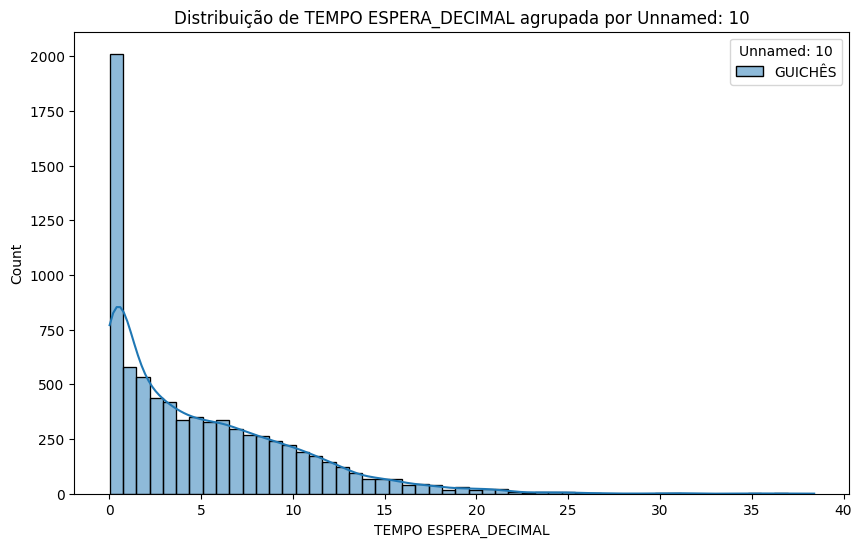

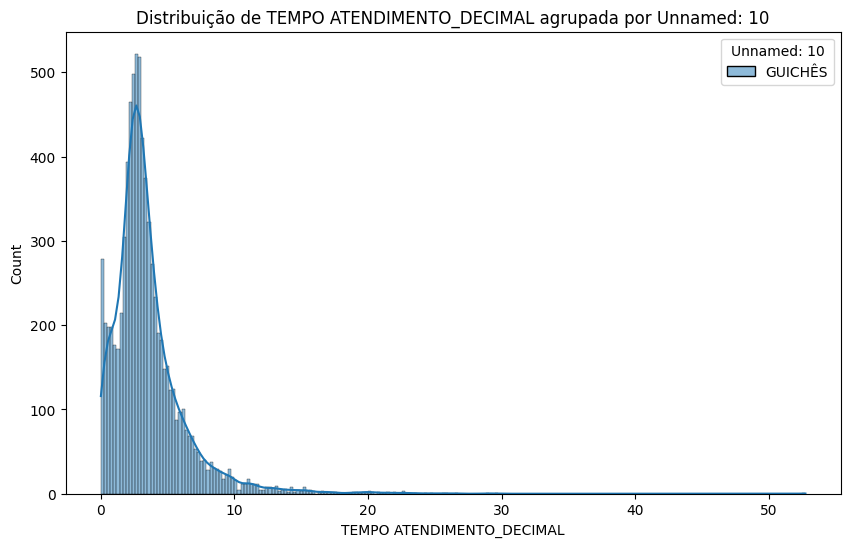

=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo GUICHÊS - Melhor distribuição: cauchy
Parâmetros da distribuição: (2.846174284278143, 2.693050137599691)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo GUICHÊS - Melhor distribuição: erlang
Parâmetros da distribuição: (0.005575770164833673, -3.621611392444619e-27, 1.4587430852121552)
Estatísticas descritivas:


In [21]:
analisar_distribuicoes_por_local(df_filtro_recepcao, colunas_decimais)

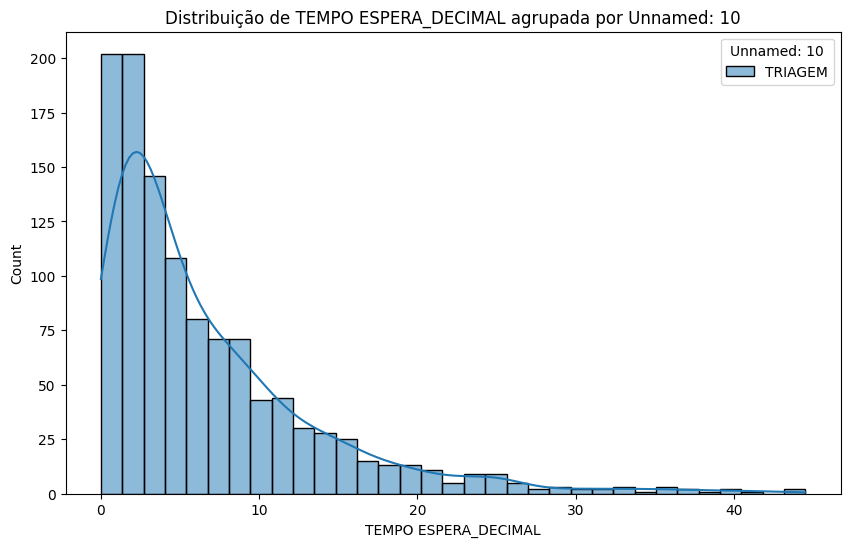

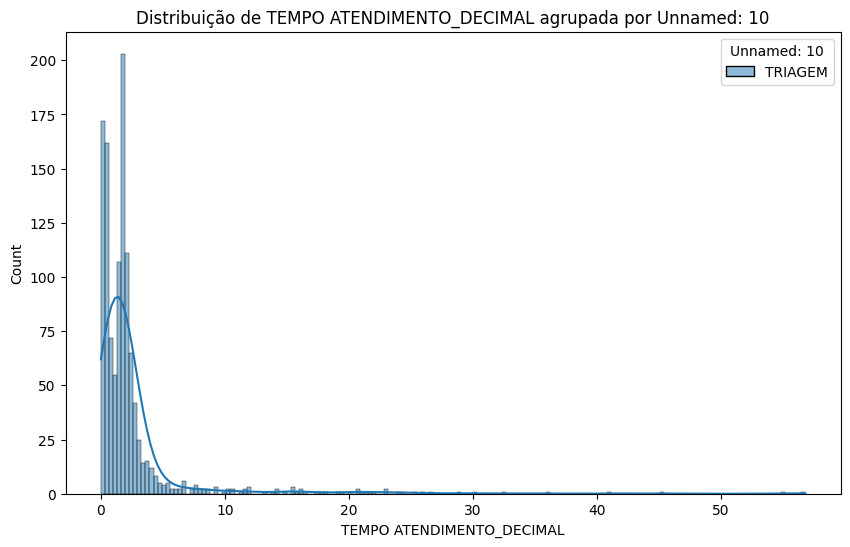

=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo TRIAGEM - Melhor distribuição: uniform
Parâmetros da distribuição: (0.016666666666666666, 44.5)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo TRIAGEM - Melhor distribuição: gamma
Parâmetros da distribuição: (0.14236613001046003, -3.8118512332226425e-28, 1.5399880321338508)
Estatísticas descritivas:


In [22]:
analisar_distribuicoes_por_local(df_filtro_triagem, colunas_decimais)

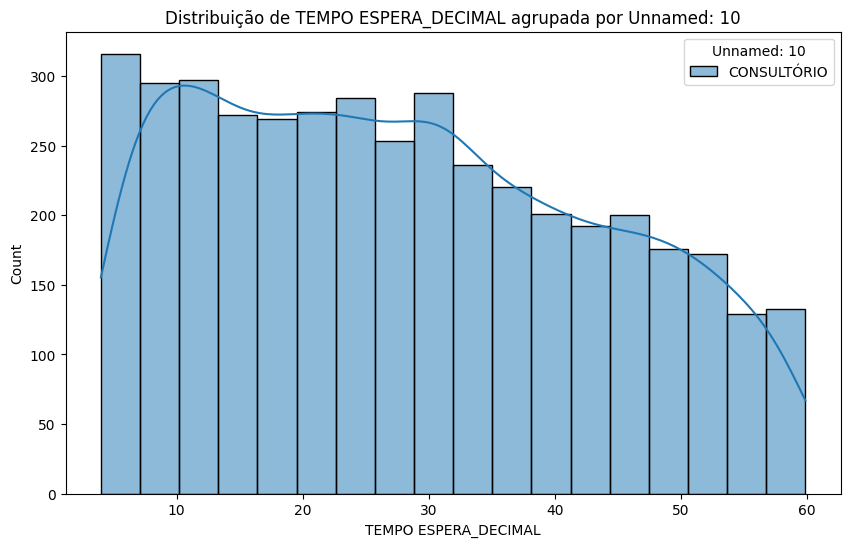

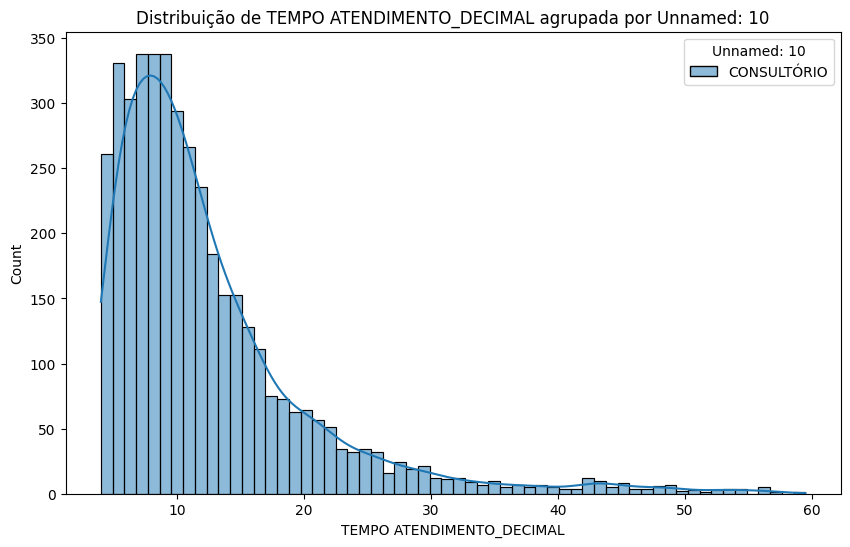

=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo CONSULTÓRIO - Melhor distribuição: cauchy
Parâmetros da distribuição: (26.174783881497703, 10.866440641166356)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo CONSULTÓRIO - Melhor distribuição: uniform
Parâmetros da distribuição: (4.0, 55.46666666666667)
Estatísticas descritivas:


In [23]:
analisar_distribuicoes_por_local(df_filtro_consultorio, colunas_decimais)

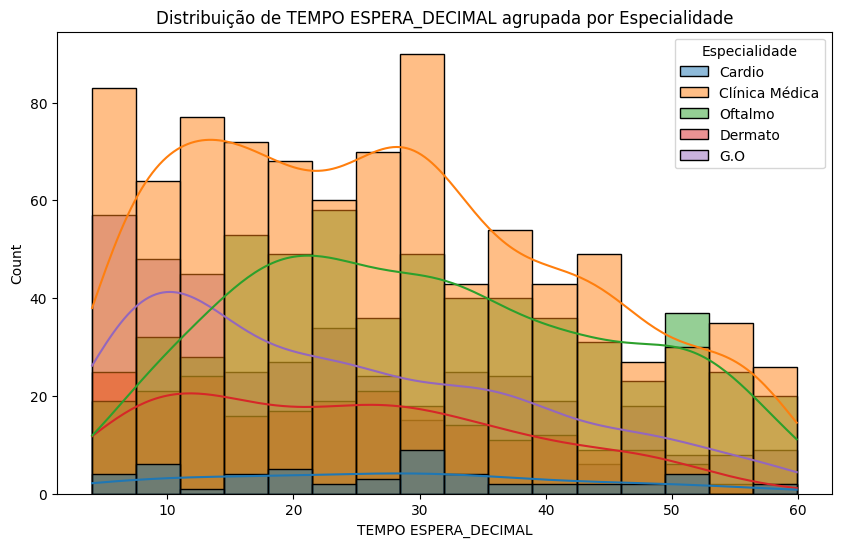

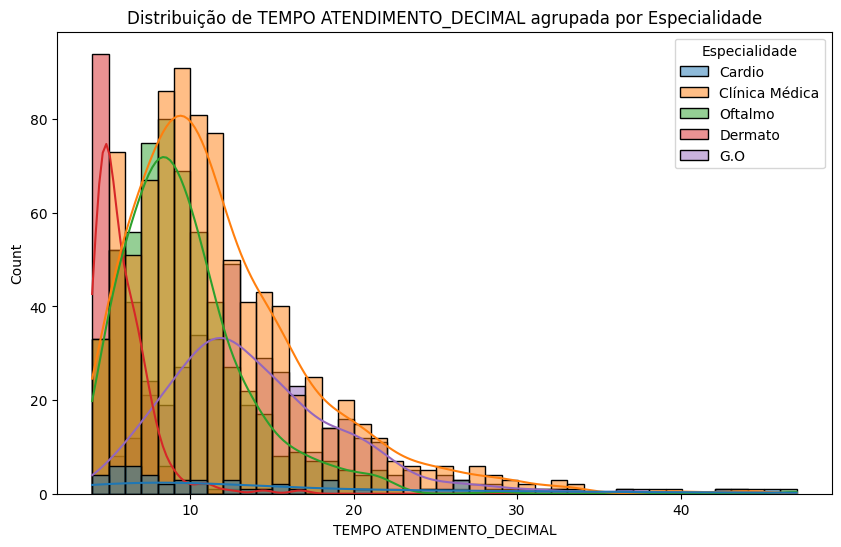

=== Resultados para TEMPO ESPERA_DECIMAL ===
Especialidade Cardio - Melhor distribuição: expon
Parâmetros da distribuição: (4.033333333333333, 23.43910256410257)
Estatísticas descritivas:
count    52.000000
mean     27.472436
std      14.890519
min       4.033333
25%      16.841667
50%      28.608333
75%      36.158333
max      58.750000
Name: TEMPO ESPERA_DECIMAL, dtype: float64


Especialidade Clínica Médica - Melhor distribuição: uniform
Parâmetros da distribuição: (4.066666666666667, 55.766666666666666)
Estatísticas descritivas:
count    891.000000
mean      27.147419
std       14.930117
min        4.066667
25%       14.358333
50%       25.950000
75%       38.108333
max       59.833333
Name: TEMPO ESPERA_DECIMAL, dtype: float64


Especialidade Dermato - Melhor distribuição: uniform
Parâmetros da distribuição: (4.050000000000001, 54.233333333333334)
Estatísticas descritivas:
count    226.000000
mean      24.389012
std       13.680219
min        4.050000
25%       12.125000
50%      

In [24]:
analisar_distribuicoes_por_atendente2(df_filtro_consultorio ,colunas_decimais)

Tentando entender os valores acima ou abaixo do normal dos dados

In [25]:
#Começando pelos valores anormais da especialidade cardiologista

df_filtrado_consultorio_cardio = df_filtro_consultorio.loc[df_filtro_consultorio['Especialidade'] == 'Cardio']
df_filtrado_consultorio_cardio = df_filtrado_consultorio_cardio.reset_index(drop=True)

In [26]:
descritivas = df_filtrado_consultorio_cardio.describe()
print(descritivas)

       EMISSAO_DECIMAL  TEMPO ESPERA_DECIMAL  TEMPO ATENDIMENTO_DECIMAL
count        52.000000             52.000000                  52.000000
mean          8.803381             27.472436                  14.939423
std           0.966062             14.890519                  11.237160
min           7.188889              4.033333                   4.316667
25%           7.960278             16.841667                   6.658333
50%           8.586528             28.608333                  10.583333
75%           9.501181             36.158333                  19.245833
max          11.367500             58.750000                  46.000000


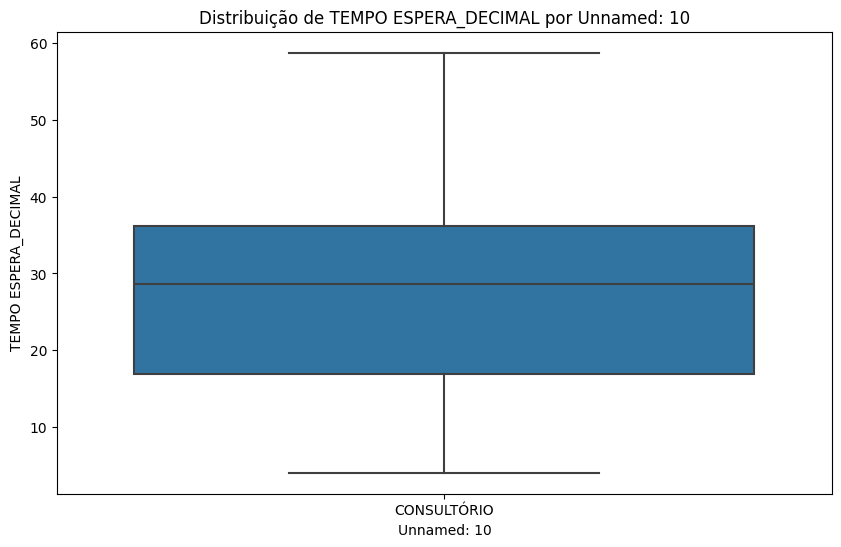

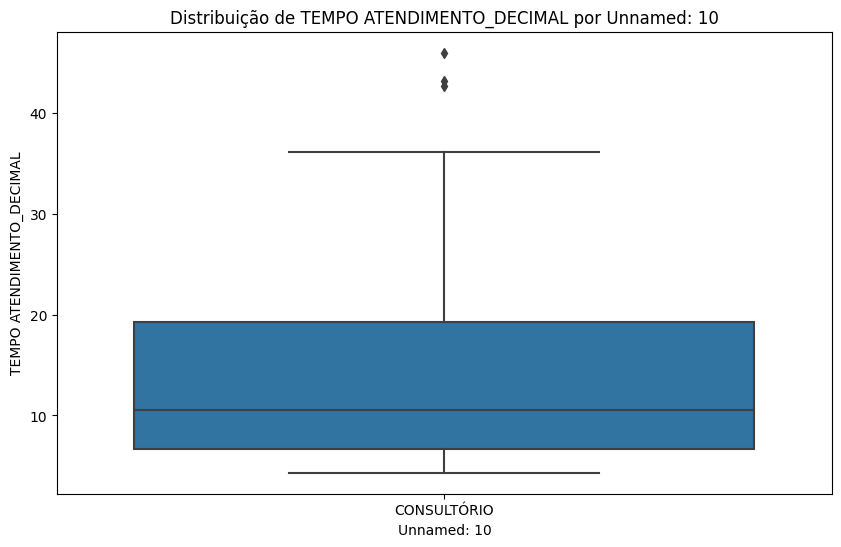

In [27]:
colunas_selecionadas = ['Unnamed: 10', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']
df_selecionado = df_filtrado_consultorio_cardio[colunas_selecionadas]

# Agrupe por 'Unnamed: 10' e calcule estatísticas descritivas
estatisticas_descritivas = df_selecionado.groupby('Unnamed: 10').describe()

# Exiba a tabela de estatísticas descritivas
estatisticas_descritivas

# Crie gráficos de caixa para cada coluna agrupada por 'Unnamed: 10'
for coluna in colunas_selecionadas[1:]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Unnamed: 10', y=coluna, data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por Unnamed: 10')
    plt.show()

In [28]:
# Filtrar linhas com TEMPO ATENDIMENTO_DECIMAL abaixo de 20
df_abaixo_20 = df_filtrado_consultorio_cardio[df_filtrado_consultorio_cardio['TEMPO ATENDIMENTO_DECIMAL'] < 20]
# Filtrar linhas com TEMPO ATENDIMENTO_DECIMAL igual ou acima de 20
df_acima_ou_igual_20 = df_filtrado_consultorio_cardio[df_filtrado_consultorio_cardio['TEMPO ATENDIMENTO_DECIMAL'] >= 20]

In [29]:
# Contagem para valores abaixo de 20
contagem_abaixo_20 = (df_filtrado_consultorio_cardio['TEMPO ATENDIMENTO_DECIMAL'] < 20).sum()
# Contagem para valores acima de 40
contagem_acima_20 = (df_filtrado_consultorio_cardio['TEMPO ATENDIMENTO_DECIMAL'] > 20).sum()

In [34]:
percent = contagem_abaixo_20 + contagem_acima_20
percent20 = (contagem_abaixo_20/percent)*100
percentacima20 = (contagem_acima_20/percent)*100
percentotal = percent20 + percent20

print("Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL quantidade abaixo de 20:", contagem_abaixo_20)
print("Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL quantidade acima de 20:", contagem_acima_20)
print("Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL percentual abaixo de 20:", percent20)
print("Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL percentual acima de 20:", percentacima20)

Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL quantidade abaixo de 20: 39
Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL quantidade acima de 20: 13
Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL percentual abaixo de 20: 75.0
Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL percentual acima de 20: 25.0


In [ ]:
df_acima_ou_igual_20

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,Especialidade
7,Gladston Vieira Costa,M42,DR. WALTER TADEU,2023-09-05,09:33:47,00:29:29,00:26:10,00:55:39,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,9.563056,29.483333,26.166667,Cardio
11,\tana Paula Leao Dos Santos,M21,DR. WALTER TADEU,2023-09-12,08:27:34,00:06:13,00:42:44,00:48:57,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.459444,6.216667,42.733333,Cardio
16,Adner Augusto Gomes,M8,DR. WALTER TADEU,2023-09-16,08:06:11,00:07:43,00:20:05,00:27:48,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.103056,7.716667,20.083333,Cardio
20,Vanilton Mendes Colares,P1,DR. WALTER TADEU,2023-09-22,07:18:45,00:12:03,00:31:48,00:43:51,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,7.312500,12.050000,31.800000,Cardio
21,Adriana Goncalves De Oliveira,M8,DR. WALTER TADEU,2023-09-22,08:13:54,00:04:02,00:43:10,00:47:12,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.231667,4.033333,43.166667,Cardio
23,Laurencia Santana,M19,DR. WALTER TADEU,2023-09-26,08:05:15,00:46:23,00:26:04,01:12:27,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.087500,46.383333,26.066667,Cardio
29,Domingas Neres Da Silva,M12,DR. WALTER TADEU,2023-10-03,07:51:18,00:43:14,00:25:04,01:08:18,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,7.855000,43.233333,25.066667,Cardio
31,Helenice Maria Maximo,M82,DR. WALTER TADEU,2023-10-03,10:19:50,00:17:28,00:32:08,00:49:36,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,10.330556,17.466667,32.133333,Cardio
32,Jose Avila Dos Santos,P3,DR. WALTER TADEU,2023-10-04,07:59:27,00:37:05,00:36:07,01:13:12,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,7.990833,37.083333,36.116667,Cardio
36,Viviane Abadia Borges Cardoso,M31,DR. WALTER TADEU,2023-10-07,10:12:56,00:19:07,00:26:18,00:45:25,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,10.215556,19.116667,26.300000,Cardio


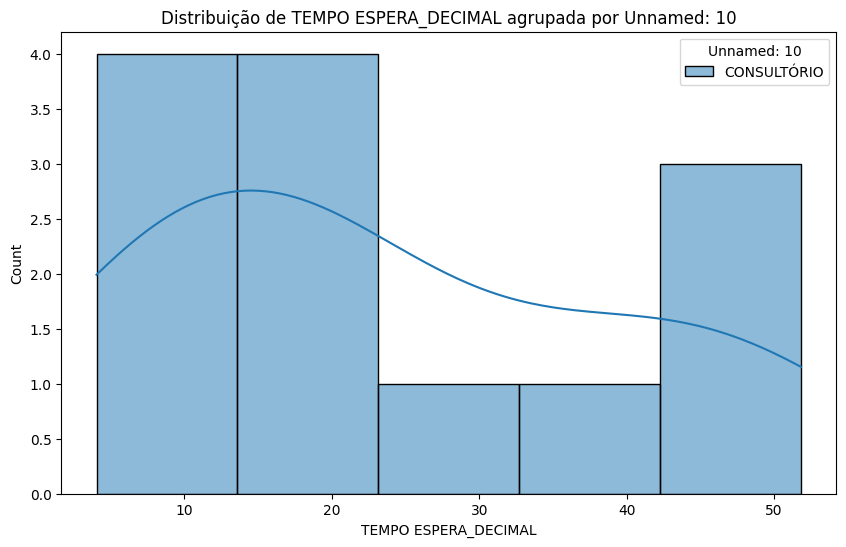

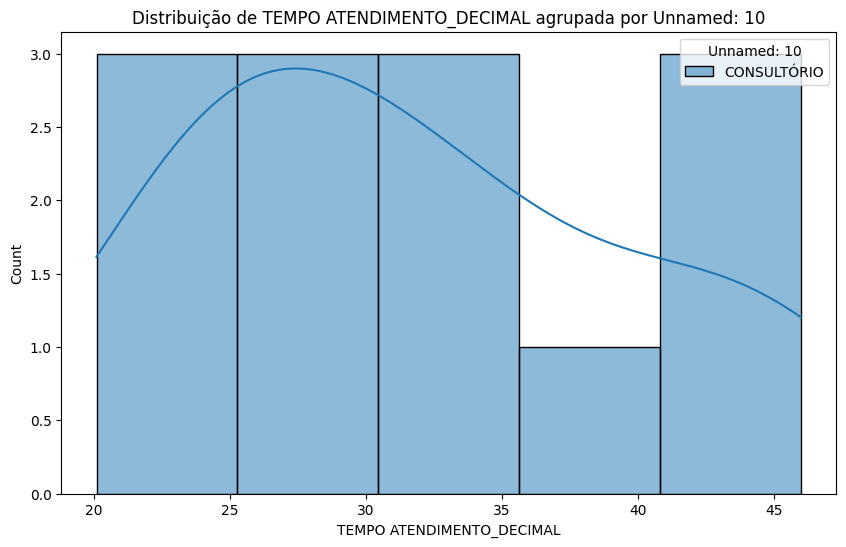

=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo CONSULTÓRIO - Melhor distribuição: triang
Parâmetros da distribuição: (0.9999999999989365, -12.893922673921555, 65.48001255361257)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo CONSULTÓRIO - Melhor distribuição: triang
Parâmetros da distribuição: (0.9998375621434317, 10.874263059189069, 35.13249578742233)
Estatísticas descritivas:


In [ ]:
analisar_distribuicoes_por_local(df_acima_ou_igual_20, colunas_decimais)

GERANDO OS DF COM BASE NOS TEMPOS ENVIADO

In [ ]:
import pandas as pd

# Supondo que você tenha um DataFrame df_filtro_consultorio

# Condições para filtrar
condicoes_filtro = {
    'Cardio': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 20),
    'Clínica Médica': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 14),
    'Oftalmo': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 13.5),
    'G.O': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 26.7),
    'Dermato': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 15),
}

# Aplicar as condições de filtro para cada especialidade
df_filtrado = pd.DataFrame()
for especialidade, condicao in condicoes_filtro.items():
    df_especialidade = df_filtro_consultorio[condicao]
    df_especialidade['Especialidade'] = especialidade
    df_filtrado = pd.concat([df_filtrado, df_especialidade])

df_filtrado


,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,Especialidade
30,Jose Nunes Da Silva,A3,DRA. CATIA FERNANDES MOREIRA,2023-09-01,08:10:06,00:43:34,00:14:08,00:57:42,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,CONSULTÓRIO,8.168333,43.566667,14.133333,Cardio
51,Elaine Maria Da Silva,P2,DR. WALTER TADEU,2023-09-01,08:52:22,00:08:16,00:05:10,00:13:26,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.872778,8.266667,5.166667,Cardio
84,Longino Goncalves Ferreira,A9,DRA. CATIA FERNANDES MOREIRA,2023-09-01,10:30:39,00:49:30,00:10:26,00:59:56,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,CONSULTÓRIO,10.510833,49.500000,10.433333,Cardio
88,Solange Moreira Herber,O2,DRA. CATIA FERNANDES MOREIRA,2023-09-01,10:43:52,00:32:10,00:05:03,00:37:13,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,CONSULTÓRIO,10.731111,32.166667,5.050000,Cardio
103,Rosana Maria De Almeida Silva,M22,DRA. POLIANA TOMAZ ROSA,2023-09-01,12:18:59,00:50:29,00:07:57,00:58:26,Dra. Poliana Tomaz Rosa,CONSULTÓRIO-5,CONSULTÓRIO,12.316389,50.483333,7.950000,Cardio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22009,Katia Maria Damasceno Da Conceicao,M208,DR. EDUARDO MIGUEL NOGUEIRA BARROS,2023-10-31,16:55:08,00:23:21,00:06:26,00:29:47,Dr. Eduardo Miguel Nogueira Barros,CONSULTÓRIO-6,CONSULTÓRIO,16.918889,23.350000,6.433333,Dermato
22010,\trayane Vitoria Fernandes De Carvalho,M209,DR. EDUARDO MIGUEL NOGUEIRA BARROS,2023-10-31,16:55:47,00:29:22,00:05:35,00:34:57,Dr. Eduardo Miguel Nogueira Barros,CONSULTÓRIO-6,CONSULTÓRIO,16.929722,29.366667,5.583333,Dermato
22011,Nicolly Beatriz Martins Freitas,A59,DRA. DENISE DOS SANTOS PASSOS,2023-10-31,16:58:08,00:09:23,00:12:24,00:21:47,Dra.Denise Dos Santos Passos,CONSULTÓRIO-05,CONSULTÓRIO,16.968889,9.383333,12.400000,Dermato
22013,Maria De Fatima De Jesus,M210,DRA. ANNELISE DE MACEDO,2023-10-31,17:05:55,00:07:48,00:07:50,00:15:38,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,17.098611,7.800000,7.833333,Dermato


In [ ]:
import pandas as pd

# Supondo que 'Especialidade' seja o nome da coluna que contém as especialidades no seu DataFrame
contagem_por_especialidade = df_filtro_consultorio['Especialidade'].value_counts()

# Exibindo a contagem total por especialidade
print(contagem_por_especialidade)


Especialidade
Clínica Médica    891
Oftalmo           576
G.O               392
Dermato           226
Cardio             52
Name: count, dtype: int64


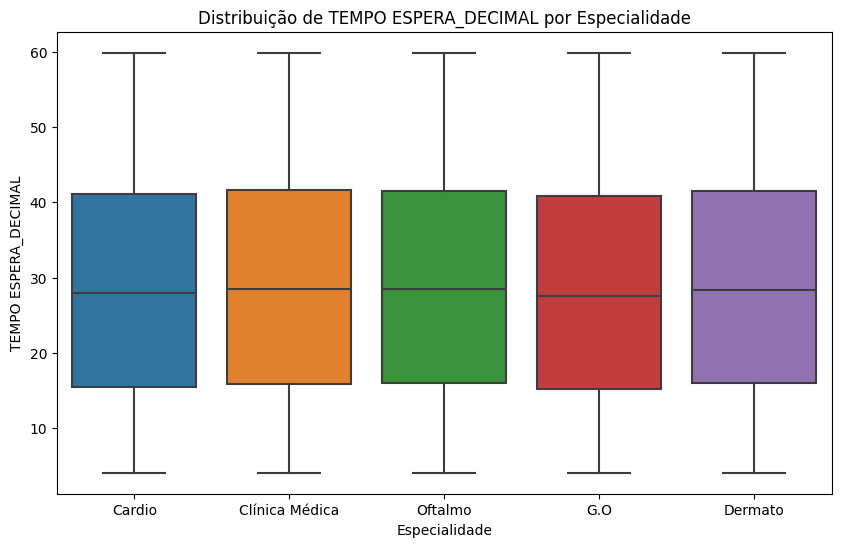

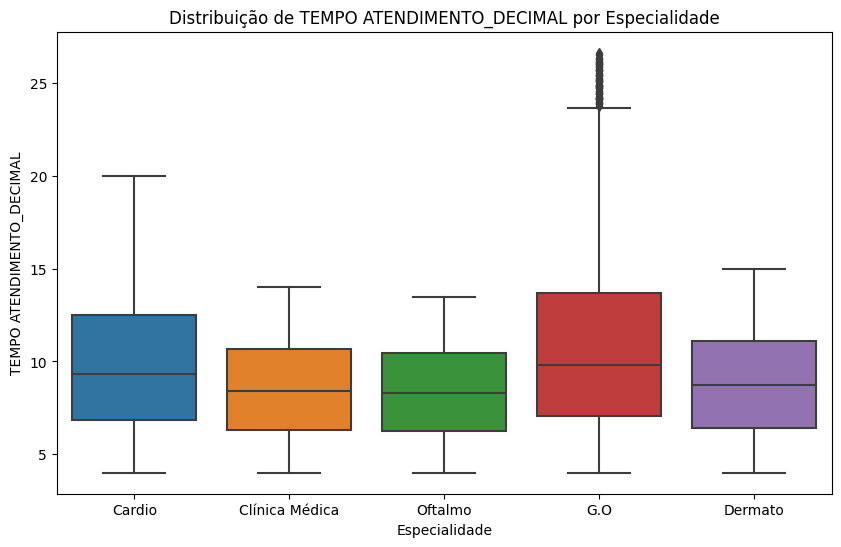

In [ ]:
colunas_selecionadas = ['Especialidade', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']
df_selecionado = df_filtrado[colunas_selecionadas]

# Agrupe por 'Unnamed: 10' e calcule estatísticas descritivas
estatisticas_descritivas = df_selecionado.groupby('Especialidade').describe()

# Exiba a tabela de estatísticas descritivas
estatisticas_descritivas

# Crie gráficos de caixa para cada coluna agrupada por 'Unnamed: 10'
for coluna in colunas_selecionadas[1:]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Especialidade', y=coluna, data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por Especialidade')
    plt.show()

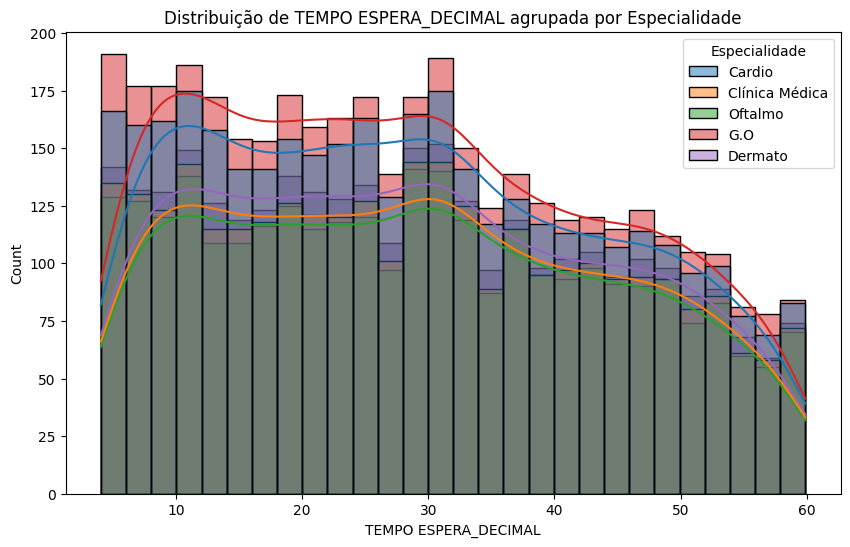

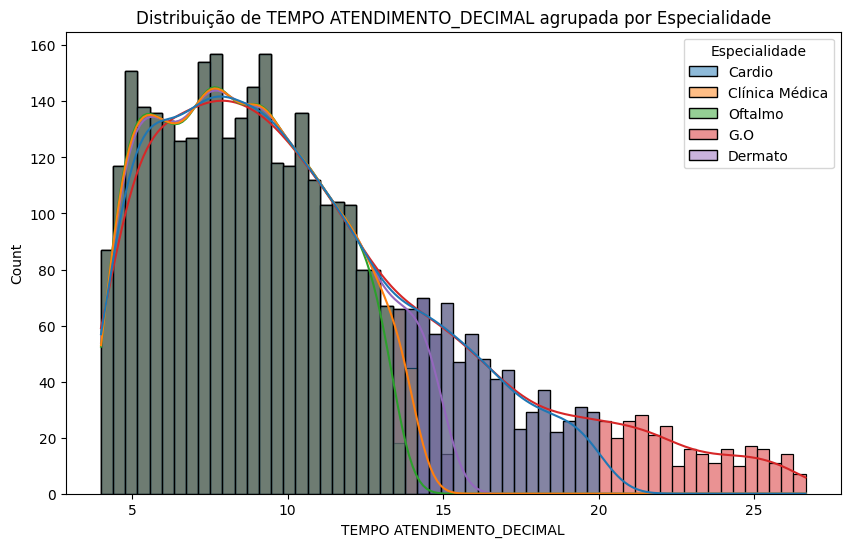

=== Resultados para TEMPO ESPERA_DECIMAL ===
Especialidade Cardio - Melhor distribuição: cauchy
Parâmetros da distribuição: (26.936905267518323, 10.86766639278803)
Estatísticas descritivas:
count    3670.000000
mean       28.684242
std        15.397634
min         4.033333
25%        15.416667
50%        27.883333
75%        41.112500
max        59.900000
Name: TEMPO ESPERA_DECIMAL, dtype: float64


Especialidade Clínica Médica - Melhor distribuição: expon
Parâmetros da distribuição: (4.033333333333333, 25.046020971302426)
Estatísticas descritivas:
count    3020.000000
mean       29.079354
std        15.407845
min         4.033333
25%        15.900000
50%        28.450000
75%        41.575000
max        59.900000
Name: TEMPO ESPERA_DECIMAL, dtype: float64


Especialidade Dermato - Melhor distribuição: expon
Parâmetros da distribuição: (4.033333333333333, 25.018929394510785)
Estatísticas descritivas:
count    3182.000000
mean       29.052263
std        15.381414
min         4.033333
25%

In [ ]:
analisar_distribuicoes_por_atendente2(df_filtrado, colunas_decimais)

Abaixo é uma tentativa de gerar uma referência com os profissionais e o conta a receber, buscando sua especialidade e vínculando o mesmo a feegow

In [ ]:
df_cr = ('''
         select tccarhn.nome_paciente as CLIENTE, tccarhn.nome_procedimento, tccarhn.datapagamento 
from pdgt_amorsaude_financeiro.fl_contas_a_receber tccarhn
where 1=1
and tccarhn.nome_procedimento like 'Consult%'
and tccarhn.nome_unidade = 'AmorSaúde Uberlândia'
''')

In [ ]:
#df = execute_athena_query(df_cr)

KeyboardInterrupt: 

In [ ]:
novos_nomes = ['CLIENTE', 'PROCEDIMENTO', 'DATA']
df.columns = novos_nomes
df.dtypes

CLIENTE         object
PROCEDIMENTO    object
DATA            object
dtype: object

In [ ]:
df1, df2, df3 = df

In [ ]:
df['DATA'] = pd.to_datetime(df['DATA'])
df.dtypes

CLIENTE                 object
PROCEDIMENTO            object
DATA            datetime64[ns]
dtype: object

In [ ]:
import re
import pandas as pd

# Função para remover caracteres especiais (exceto espaços)
def remover_caracteres_especiais(nome):
    if isinstance(nome, str):
        return re.sub(r'[^A-Za-z0-9 ]', '', nome)
    else:
        return nome

# Aplicar a função à coluna 'CLIENTE'
df['CLIENTE'] = df['CLIENTE'].apply(remover_caracteres_especiais)

# Exibir o DataFrame resultante
print(df)

                               CLIENTE             PROCEDIMENTO       DATA
0                 Jose Manoel De Souza    Consulta Oftalmologia 2021-01-06
1                 Josefina Silva Costa     Consulta Ginecologia 2021-01-06
2               Daniela Neves De Souza     Consulta Ginecologia 2021-01-08
3           Rosali Da Silva Rosa David     Consulta Ginecologia 2021-01-08
4             Carolina De Fatima Rocha  Consulta Clinica Médica 2021-01-11
...                                ...                      ...        ...
98894  RAQUEL DE ARAUJO MATOS DE SOUZA     Consulta Psiquiatria 2024-01-10
98895     Leandro Silva Pina De Campos    Consulta Oftalmologia 2024-01-10
98896          GABRIELA ALMEIDA SANTOS      Consulta Psicologia 2024-01-10
98897           Italo Pereira Dos Reis      Consulta Psicologia 2024-01-10
98898      Cristiane Aparecida Martins    Consulta Dermatologia 2024-01-10

[98899 rows x 3 columns]


In [ ]:
df_merged = pd.merge(dfrelatorio_atendimento, df, on=['CLIENTE', 'DATA'], how='left')
df_merged

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,PROCEDIMENTO
0,NaN,E1,EXAMES,2023-09-01,07:03:21,00:00:39,00:00:01,00:00:40,Debora Silva Lopes,GUICHÊS-2,GUICHÊS,7.055833,0.650000,0.016667,NaN
1,NaN,E2,EXAMES,2023-09-01,07:11:05,00:00:11,00:00:25,00:00:36,Debora Silva Lopes,GUICHÊS-2,GUICHÊS,7.184722,0.183333,0.416667,NaN
2,NaN,P1,ULTRASSOM,2023-09-01,07:18:43,00:00:58,00:01:35,00:02:33,Giovana Cristina,GUICHÊS-1,GUICHÊS,7.311944,0.966667,1.583333,NaN
3,Jose Ricardo De Paula Nunes,M1,ATENDIMENTO MEDICO,2023-09-01,07:18:52,00:06:52,00:03:34,00:10:26,Ivina Renata,GUICHÊS-02,GUICHÊS,7.314444,6.866667,3.566667,NaN
4,NaN,E3,EXAMES,2023-09-01,07:21:45,00:00:16,00:00:20,00:00:36,Giovana Cristina,GUICHÊS-1,GUICHÊS,7.362500,0.266667,0.333333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21469,Maria De Fatima De Jesus,M210,ATENDIMENTO MEDICO,2023-10-31,17:05:55,00:00:04,00:00:27,00:00:31,Ivina Renata,GUICHÊS-01,GUICHÊS,17.098611,0.066667,0.450000,Consulta Oftalmologia
21470,Maria De Fatima De Jesus,M210,DRA. ANNELISE DE MACEDO,2023-10-31,17:05:55,00:07:48,00:07:50,00:15:38,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,17.098611,7.800000,7.833333,Consulta Oftalmologia
21471,Brayan Fernandes De Jesus,A60,DRA. DENISE DOS SANTOS PASSOS,2023-10-31,17:12:42,00:20:15,00:07:33,00:27:48,Dra.Denise Dos Santos Passos,CONSULTÓRIO-05,CONSULTÓRIO,17.211667,20.250000,7.550000,NaN
21472,NaN,R23,RESULTADO DE EXAMES,2023-10-31,17:32:14,00:19:45,00:00:02,00:19:47,Ivina Renata,GUICHÊS-01,GUICHÊS,17.537222,19.750000,0.033333,NaN


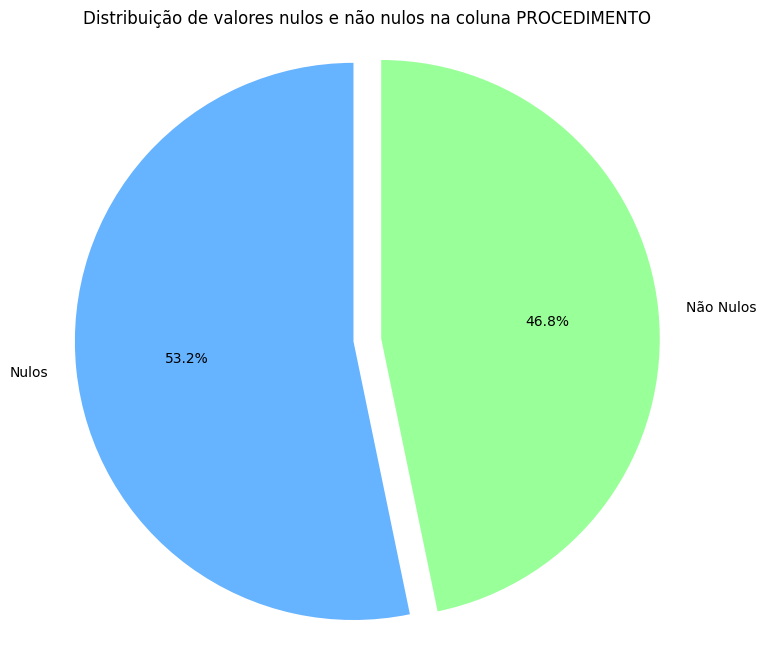

In [ ]:
# Contagem de valores nulos e não nulos na coluna 'PROCEDIMENTO'
contagem_valores = df_merged['PROCEDIMENTO'].isnull().value_counts()

# Criar um gráfico de pizza
labels = ['Nulos', 'Não Nulos']
colors = ['#66b3ff', '#99ff99']
explode = (0.1, 0)  # Explodir a primeira fatia (Não Nulos)

plt.pie(contagem_valores, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=90)
plt.title('Distribuição de valores nulos e não nulos na coluna PROCEDIMENTO')
plt.axis('equal')  # Assegura que o gráfico de pizza seja desenhado como um círculo.

plt.show()

In [ ]:
contagem_procedimento = df_merged.groupby('Unnamed: 10')['PROCEDIMENTO'].count()

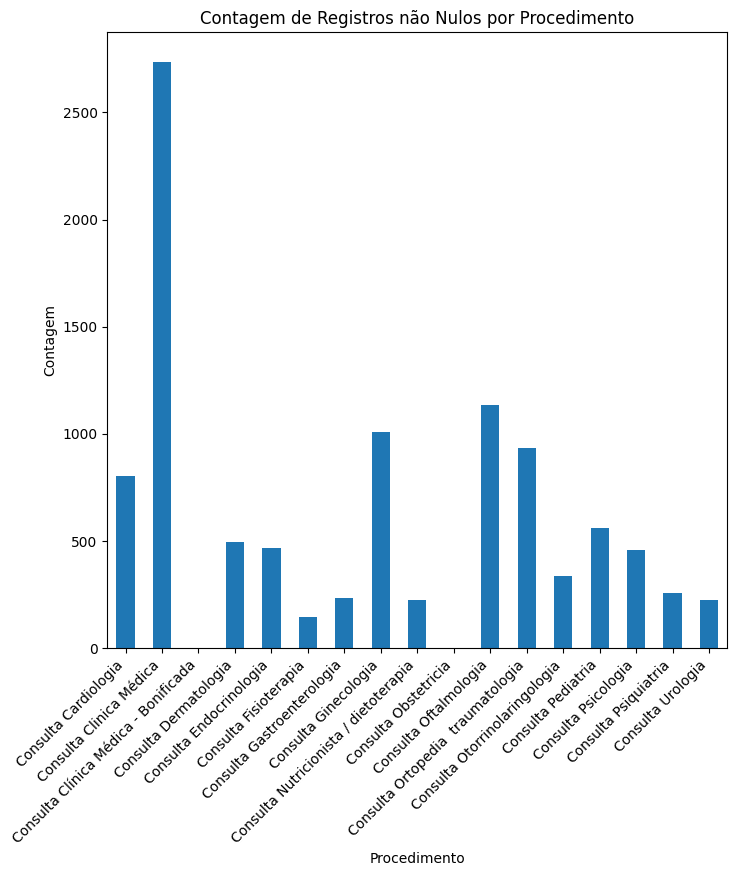

In [ ]:
contagem_procedimento = df_merged.groupby('PROCEDIMENTO').size()
contagem_procedimento.plot(kind='bar', rot=0)
plt.title('Contagem de Registros não Nulos por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.show()

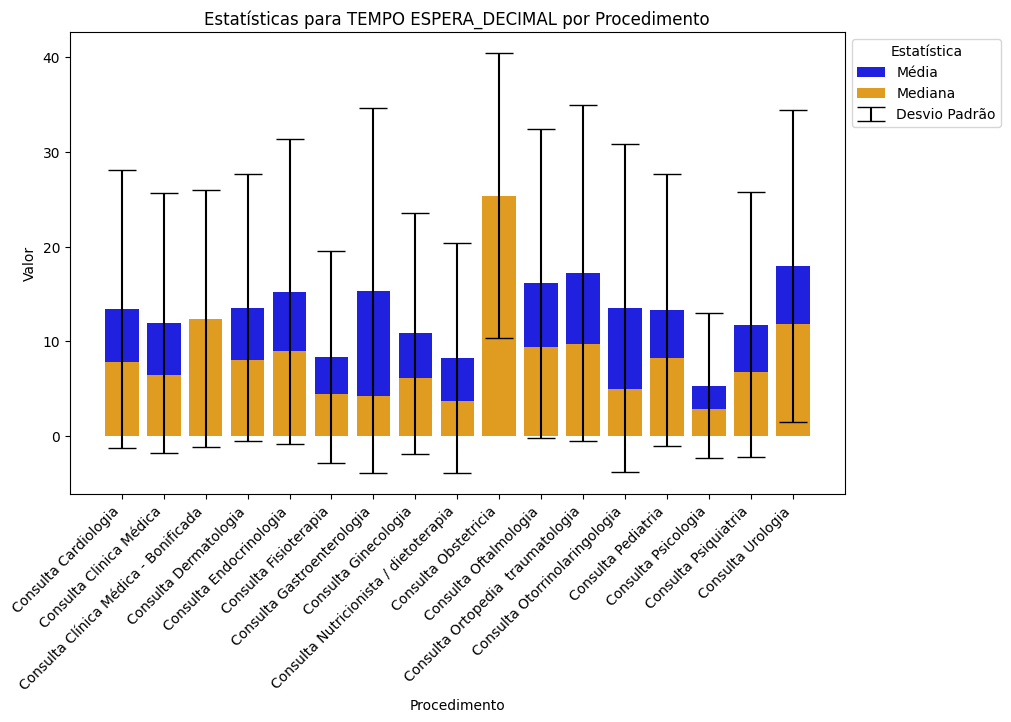

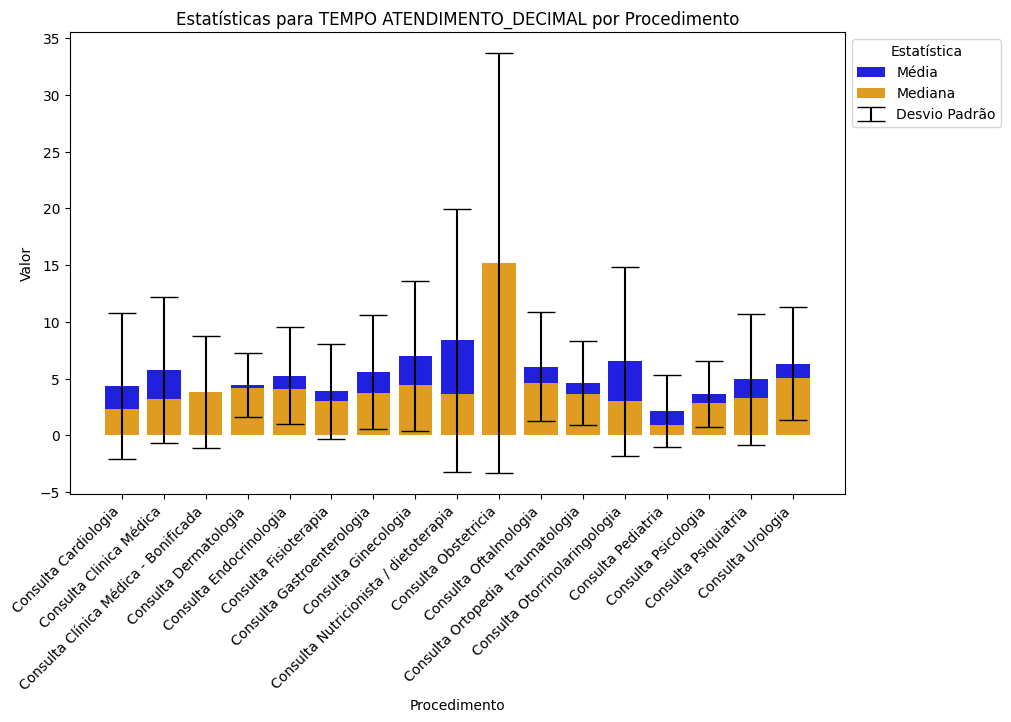

In [ ]:
# Calcular média, mediana e desvio padrão para TEMPO ESPERA_DECIMAL
estatisticas_tempo_espera = df_merged.groupby('PROCEDIMENTO')['TEMPO ESPERA_DECIMAL'].agg(['mean', 'median', 'std'])

# Calcular média, mediana e desvio padrão para TEMPO ATENDIMENTO_DECIMAL
estatisticas_tempo_atendimento = df_merged.groupby('PROCEDIMENTO')['TEMPO ATENDIMENTO_DECIMAL'].agg(['mean', 'median', 'std'])

# Criar gráfico para TEMPO ESPERA_DECIMAL
plt.figure(figsize=(10, 6))
sns.barplot(x='PROCEDIMENTO', y='mean', data=estatisticas_tempo_espera.reset_index(), label='Média', color='blue')
sns.barplot(x='PROCEDIMENTO', y='median', data=estatisticas_tempo_espera.reset_index(), label='Mediana', color='orange')
plt.errorbar(x=estatisticas_tempo_espera.reset_index()['PROCEDIMENTO'], y=estatisticas_tempo_espera['mean'], yerr=estatisticas_tempo_espera['std'], fmt='none', color='black', capsize=10, label='Desvio Padrão')
plt.title('Estatísticas para TEMPO ESPERA_DECIMAL por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Valor')
plt.legend(title='Estatística', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # ha='right' ajusta a posição dos rótulos para evitar sobreposições
plt.show()

# Criar gráfico para TEMPO ATENDIMENTO_DECIMAL
plt.figure(figsize=(10, 6))
sns.barplot(x='PROCEDIMENTO', y='mean', data=estatisticas_tempo_atendimento.reset_index(), label='Média', color='blue')
sns.barplot(x='PROCEDIMENTO', y='median', data=estatisticas_tempo_atendimento.reset_index(), label='Mediana', color='orange')
plt.errorbar(x=estatisticas_tempo_atendimento.reset_index()['PROCEDIMENTO'], y=estatisticas_tempo_atendimento['mean'], yerr=estatisticas_tempo_atendimento['std'], fmt='none', color='black', capsize=10, label='Desvio Padrão')
plt.title('Estatísticas para TEMPO ATENDIMENTO_DECIMAL por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Valor')
plt.legend(title='Estatística', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # ha='right' ajusta a posição dos rótulos para evitar sobreposições
plt.show()

In [ ]:
df_merged = df_merged.dropna(subset=['PROCEDIMENTO'])
df_filtrado_outliers = df_merged[(df_merged['Unnamed: 10'] == 'GUICHÊS') | (df_merged['Unnamed: 10'] == 'TRIAGEM')]


In [ ]:
df_filtrado_outliers

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,PROCEDIMENTO
9,Jesuina Candida Da Silva,P1,MEDICO PREFERENCIAL,2023-09-01,07:35:15,00:00:07,00:05:27,00:05:34,Ivina Renata,GUICHÊS-02,GUICHÊS,7.587500,0.116667,5.450000,Consulta Cardiologia
18,Rita De Cassia Medeiros,M2,ATENDIMENTO MEDICO,2023-09-01,07:51:54,00:00:05,00:08:09,00:08:14,Ivina Renata,GUICHÊS-02,GUICHÊS,7.865000,0.083333,8.150000,Consulta Cardiologia
20,Catarina Da Silva Costa,M3,ATENDIMENTO MEDICO,2023-09-01,07:53:23,00:00:25,00:01:44,00:02:09,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,7.889722,0.416667,1.733333,Consulta Psicologia
30,Gilma Gomes Dos Reis Lopes,F2,FISIOTERAPIA,2023-09-01,08:19:07,00:00:09,00:02:41,00:02:50,Ivina Renata,GUICHÊS-02,GUICHÊS,8.318611,0.150000,2.683333,Consulta Fisioterapia
35,Nair Amaro Dos Reis Dias,M5,ATENDIMENTO MEDICO,2023-09-01,08:36:04,00:00:40,00:00:27,00:01:07,Ana Carolina Martins Andrade Gomes,GUICHÊS-1,GUICHÊS,8.601111,0.666667,0.450000,Consulta Cardiologia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21445,Clara Cruvinel,M200,ATENDIMENTO MEDICO,2023-10-31,16:37:17,00:00:09,00:02:27,00:02:36,Ivina Renata,GUICHÊS-01,GUICHÊS,16.621389,0.150000,2.450000,Consulta Ortopedia traumatologia
21448,Maria Madalena Da Silva Melo,M201,ATENDIMENTO MEDICO,2023-10-31,16:40:46,00:00:03,00:05:05,00:05:08,Ivina Renata,GUICHÊS-01,GUICHÊS,16.679444,0.050000,5.083333,Consulta Nutricionista / dietoterapia
21451,Cheyenne Mota De Lima,M203,ATENDIMENTO MEDICO,2023-10-31,16:44:31,00:01:39,00:03:43,00:05:22,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,16.741944,1.650000,3.716667,Consulta Oftalmologia
21453,Eli Vieira De Lima,M204,ATENDIMENTO MEDICO,2023-10-31,16:46:59,00:00:07,00:02:43,00:02:50,Taina Matias,GUICHÊS-2,GUICHÊS,16.783056,0.116667,2.716667,Consulta Ortopedia traumatologia


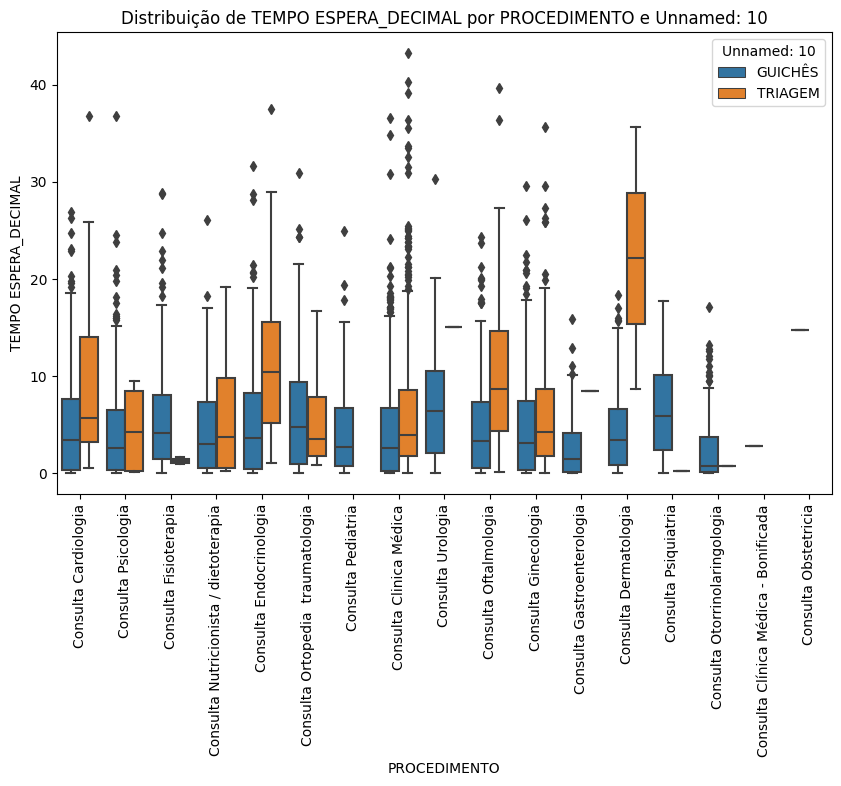

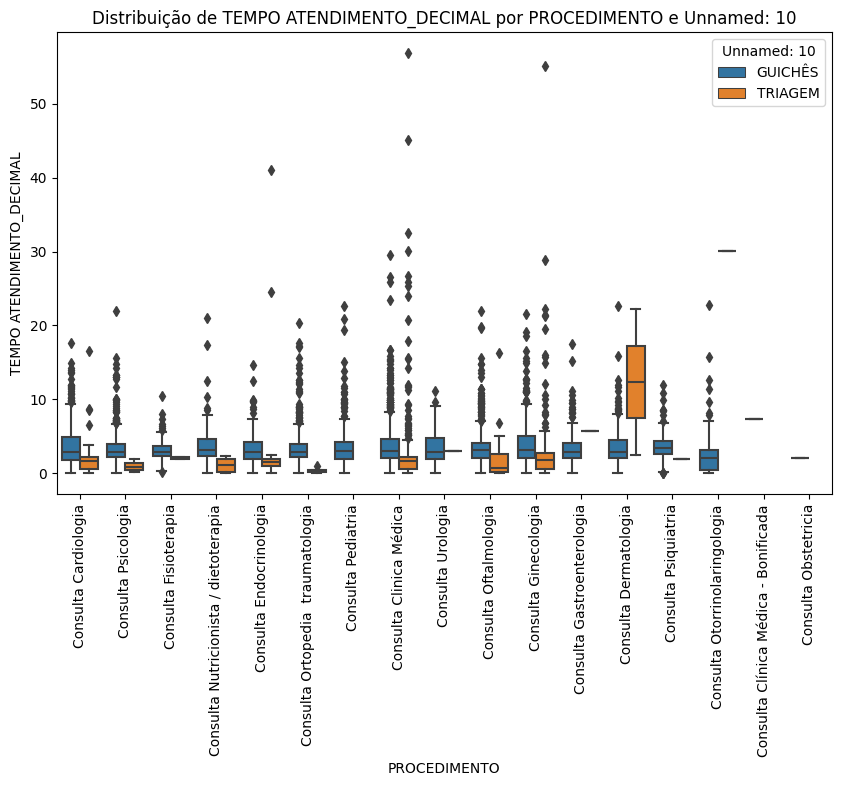

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1000x600 with 0 Axes>

In [ ]:
colunas_selecionadas = ['TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL', 'PROCEDIMENTO', 'Unnamed: 10']
df_selecionado = df_filtrado_outliers[colunas_selecionadas]

# Crie gráficos de caixa individuais para cada coluna agrupada por 'PROCEDIMENTO' e 'Unnamed: 10'
for coluna in colunas_selecionadas[:-1]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='PROCEDIMENTO', y=coluna, hue='Unnamed: 10', data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por PROCEDIMENTO e Unnamed: 10')
    plt.xticks(rotation=90)  # Gira o eixo x em 90 graus
    plt.show()

In [ ]:
#pip install pyod

In [ ]:
from pyod.models.iforest import IForest

X = df_filtrado_outliers[['TEMPO ATENDIMENTO_DECIMAL']]

clf = IForest(contamination=0.05, random_state=42)

# Ajuste o modelo aos dados
clf.fit(X)

df_filtrado_outliers['outlier'] = clf.predict(X)

# Filtrar apenas os outliers na categoria 'Unnamed: 10'
outliers_unnamed10 = df_filtrado_outliers[df_filtrado_outliers['outlier'] == 1]

outliers_unnamed10

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,PROCEDIMENTO,outlier
117,Alexsander Raniere Mota,M28,DRA. POLIANA TOMAZ ROSA,2023-09-01,13:24:08,00:01:06,00:24:29,00:25:35,Millena Misael,TRIAGEM-1,TRIAGEM,13.402222,1.100000,24.483333,Consulta Endocrinologia,1
353,Leocadio Rosa De Jesus,M42,DRA. LUDIMILA VIANA,2023-09-02,09:43:53,00:12:18,00:25:49,00:38:07,Millena Misael,TRIAGEM-1,TRIAGEM,9.731389,12.300000,25.816667,Consulta Clinica Médica,1
452,Eliel Da Silva Honorio,M13,ATENDIMENTO MEDICO,2023-09-04,07:47:44,00:12:51,00:10:04,00:22:55,Ivina Renata,GUICHÊS-02,GUICHÊS,7.795556,12.850000,10.066667,Consulta Clinica Médica,1
601,Bianca Ferreira,M62,ATENDIMENTO MEDICO,2023-09-04,10:04:04,00:05:49,00:11:26,00:17:15,Ivina Renata,GUICHÊS-02,GUICHÊS,10.067778,5.816667,11.433333,Consulta Clinica Médica,1
624,Claudiana Genuino Dos Santos,M67,ATENDIMENTO MEDICO,2023-09-04,10:31:24,00:00:09,00:09:55,00:10:04,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,10.523333,0.150000,9.916667,Consulta Endocrinologia,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21164,Genadir Jose Dias,P7,MEDICO PREFERENCIAL,2023-10-31,10:33:59,00:04:24,00:09:39,00:14:03,Ivina Renata,GUICHÊS-01,GUICHÊS,10.566389,4.400000,9.650000,Consulta Cardiologia,1
21165,Genadir Jose Dias,P7,MEDICO PREFERENCIAL,2023-10-31,10:33:59,00:04:24,00:09:39,00:14:03,Ivina Renata,GUICHÊS-01,GUICHÊS,10.566389,4.400000,9.650000,Consulta Dermatologia,1
21193,Rafael Oliveira De Souza,M106,ATENDIMENTO MEDICO,2023-10-31,11:06:08,00:02:19,00:22:35,00:24:54,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,11.102222,2.316667,22.583333,Consulta Dermatologia,1
21209,Marlene De Freitas Borges,M112,ATENDIMENTO MEDICO,2023-10-31,11:47:11,00:02:13,00:08:46,00:10:59,Ivina Renata,GUICHÊS-01,GUICHÊS,11.786389,2.216667,8.766667,Consulta Dermatologia,1


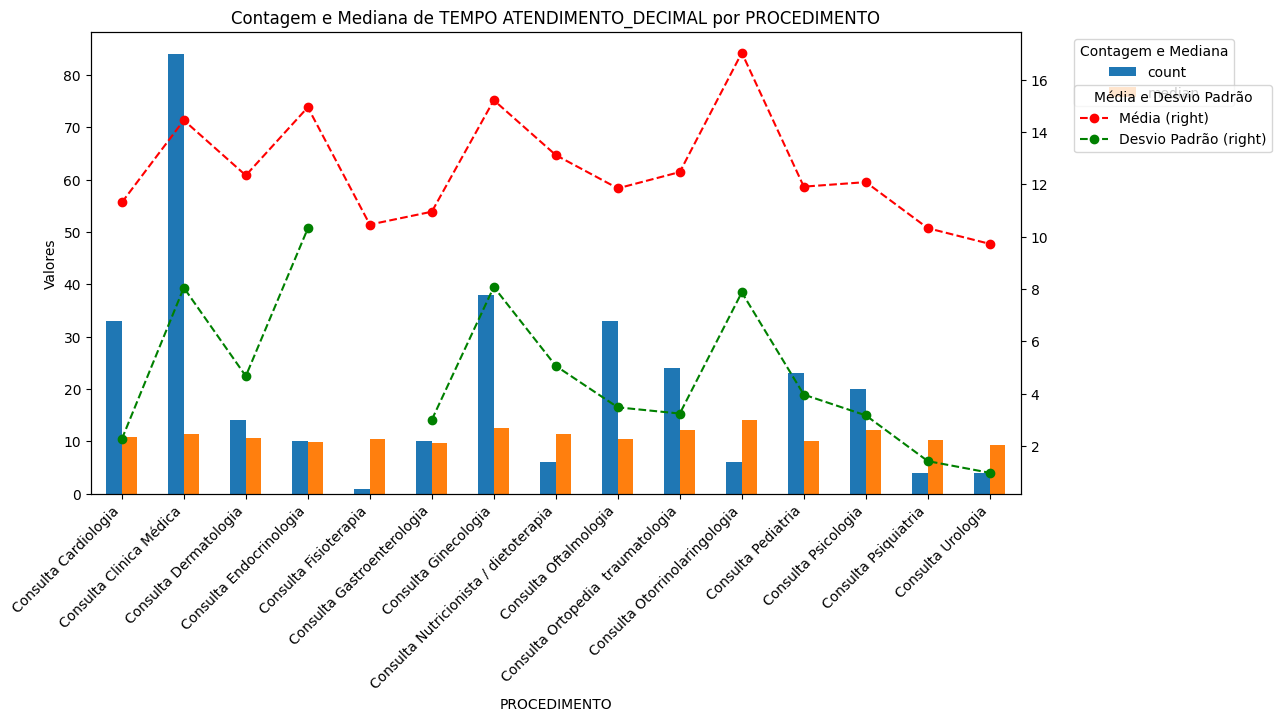

In [ ]:
summary_stats = outliers_unnamed10.groupby('PROCEDIMENTO')['TEMPO ATENDIMENTO_DECIMAL'].agg(['count', 'median'])

# Calcula a média e o desvio padrão de TEMPO ATENDIMENTO_DECIMAL para cada PROCEDIMENTO
mean_std_stats = outliers_unnamed10.groupby('PROCEDIMENTO')['TEMPO ATENDIMENTO_DECIMAL'].agg(['mean', 'std'])

# Cria o gráfico de barras para contagem e mediana
fig, ax = plt.subplots(figsize=(12, 6))
summary_stats.plot(kind='bar', ax=ax)
ax.set_title('Contagem e Mediana de TEMPO ATENDIMENTO_DECIMAL por PROCEDIMENTO')
ax.set_ylabel('Valores')

# Adiciona as linhas para média e desvio padrão
mean_std_stats['mean'].plot(ax=ax, linestyle='--', marker='o', color='red', secondary_y=True, label='Média')
mean_std_stats['std'].plot(ax=ax, linestyle='--', marker='o', color='green', secondary_y=True, label='Desvio Padrão')

# Rotaciona os rótulos do eixo x em 45 graus
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adiciona as legendas
ax.legend(title='Contagem e Mediana', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.right_ax.legend(title='Média e Desvio Padrão', bbox_to_anchor=(1.05, 0.9), loc='upper left')


plt.show()

In [ ]:
from pyod.models.iforest import IForest


X = df_merged[['TEMPO ATENDIMENTO_DECIMAL']]

# Crie o modelo Isolation Forest do PyOD
clf = IForest(contamination=0.05, random_state=42)

# Ajuste o modelo aos dados
clf.fit(X)

# Adicione uma coluna 'outlier' indicando se cada ponto é um outlier ou não
df_merged['outlier'] = clf.predict(X)

# Filtrar apenas os outliers na categoria 'Unnamed: 10'
outliers_unnamed10 = df_merged[df_merged['outlier'] == 1]

outliers_unnamed10

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,PROCEDIMENTO,outlier
101,Neusa Teles,M23,DRA. ROSELI MARIA DE OLIVEIRA,2023-09-01,12:47:49,00:15:49,00:19:26,00:35:15,Dra. Roseli Maria De Oliveira Carvalho\t,CONSULTÓRIO-6,CONSULTÓRIO,12.796944,15.816667,19.433333,Consulta Cardiologia,1
104,Berenice Vieira Freitas De Oliveira,P4,DRA. POLIANA TOMAZ ROSA,2023-09-01,12:55:04,00:03:23,00:17:35,00:20:58,Dra. Poliana Tomaz Rosa,CONSULTÓRIO-5,CONSULTÓRIO,12.917778,3.383333,17.583333,Consulta Endocrinologia,1
113,Antonia Joselina Rosa,M27,DRA. ROSELI MARIA DE OLIVEIRA,2023-09-01,13:10:52,00:12:23,00:26:14,00:38:37,Dra. Roseli Maria De Oliveira Carvalho\t,CONSULTÓRIO-6,CONSULTÓRIO,13.181111,12.383333,26.233333,Consulta Cardiologia,1
117,Alexsander Raniere Mota,M28,DRA. POLIANA TOMAZ ROSA,2023-09-01,13:24:08,00:01:06,00:24:29,00:25:35,Millena Misael,TRIAGEM-1,TRIAGEM,13.402222,1.100000,24.483333,Consulta Endocrinologia,1
144,Laiany Fatima Barcelos Dos Reis,M31,DRA. ROSELI MARIA DE OLIVEIRA,2023-09-01,13:33:03,00:01:08,00:23:24,00:24:32,Dra. Roseli Maria De Oliveira Carvalho\t,CONSULTÓRIO-6,CONSULTÓRIO,13.550833,1.133333,23.400000,Consulta Cardiologia,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20873,Celma De Fatima Mota,M88,DR.FRANSERGIO FERREIRA,2023-10-30,15:52:56,00:04:05,00:20:25,00:24:30,Dr. Fransergio Ferreira,CONSULTÓRIO-1,CONSULTÓRIO,15.882222,4.083333,20.416667,Consulta Clinica Médica,1
21116,Bruno Ricardo De Castro Vieira,M68,DRA. MILENA BRASILEIRO,2023-10-31,09:49:19,00:52:54,00:16:59,01:09:53,Dra. Milena Brasileiro,CONSULTÓRIO-6,CONSULTÓRIO,9.821944,52.900000,16.983333,Consulta Psiquiatria,1
21193,Rafael Oliveira De Souza,M106,ATENDIMENTO MEDICO,2023-10-31,11:06:08,00:02:19,00:22:35,00:24:54,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,11.102222,2.316667,22.583333,Consulta Dermatologia,1
21243,Raymunda Porcino De Barros Couto,M126,DRA. ANNELISE DE MACEDO,2023-10-31,13:40:18,00:41:57,00:17:15,00:59:12,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,13.671667,41.950000,17.250000,Consulta Oftalmologia,1
